# FINM 367 - TA Review Session 8
Tobias Rodriguez del Pozo

tobiasdelpozo@uchicago.edu

Agenda for today:
1. Risk Decomposition (AKA. feature engineering)

## 1. Risk Decomposition

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sys 

sys.path.append('../cmds/')
import TA_utils as ta 


plt.style.use('ggplot')

# Read ltcm_exhibits_data.xlsx and get sheet Exhibit 2
ltcm = pd.read_excel('../data/ltcm_exhibits_data.xlsx', sheet_name='Exhibit 2', skiprows=2, index_col=0, parse_dates=[0]).iloc[:-4, :]
ltcm.index.name = 'Date'

# Get SPY returns from returns (total) in gmo_analysis_data.xlsx
spy = pd.read_excel('../data/gmo_analysis_data.xlsx', sheet_name='total returns', index_col=0, parse_dates=[0])[['SPY']]
us3m = pd.read_excel('../data/gmo_analysis_data.xlsx', sheet_name='risk-free rate', index_col=0, parse_dates=[0])[['TBill 3M']]

# Make index a dateindex not a timestamp for ltcm
ltcm.index = pd.to_datetime(ltcm.index, format='%Y-%m-%d') + pd.tseries.offsets.MonthEnd(0)

ltcm = ltcm[['Net Monthly Performanceb']].dropna()
ltcm = ltcm.rename(columns={'Net Monthly Performanceb': 'LTCM'})

# Join on month and year of the index
df = ltcm.join(spy, how='inner').join(us3m, how='inner')

What are we actually doing in HW8? 

What we're trying to do is to test the sensitivity of a portfolio to different risk factors. So, as a toy example:

Text(0.5, 0, 'SPY')

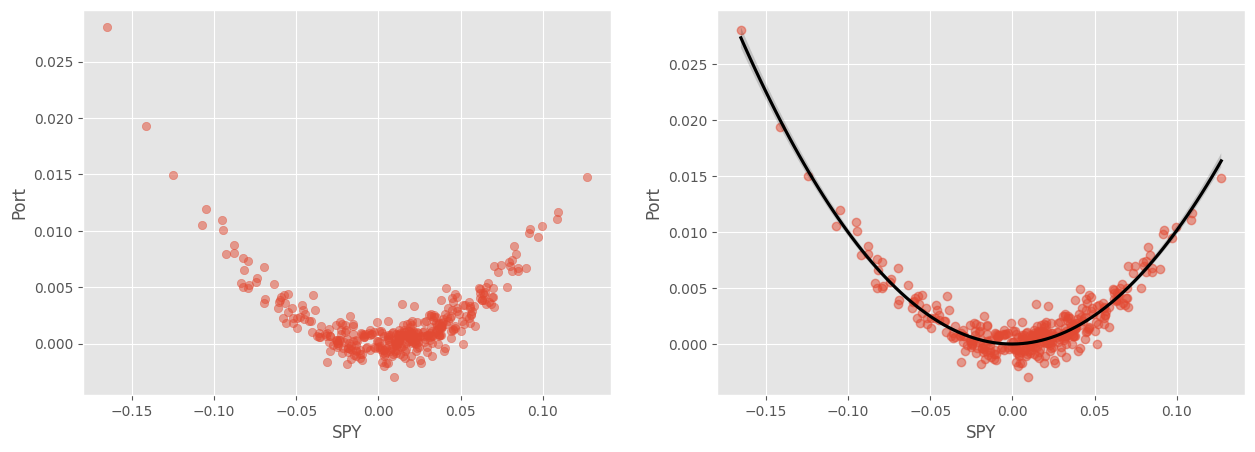

In [47]:
# Make our portfolio follow the -market^2 when market is down, and market when market is up
ex = spy.copy()
ex['Port'] = spy ** 2
# Add noise
ex['Port'] = ex['Port'] + np.random.normal(0, 0.001, size=len(ex))

# Make 2x1 subplots
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
axes[0].scatter(ex['SPY'], ex['Port'], alpha=0.5)

# Take fit linear regression (quadratic)
sns.regplot(x='SPY', y='Port', data=ex, ax=axes[1], order=2, scatter_kws={'alpha': 0.5}, line_kws={'color': 'black'})

axes[0].set_ylabel('Port')
axes[0].set_xlabel('SPY')

Gamma/delta

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ysUpN7qsoEA8JvTuErUfKQ.png)

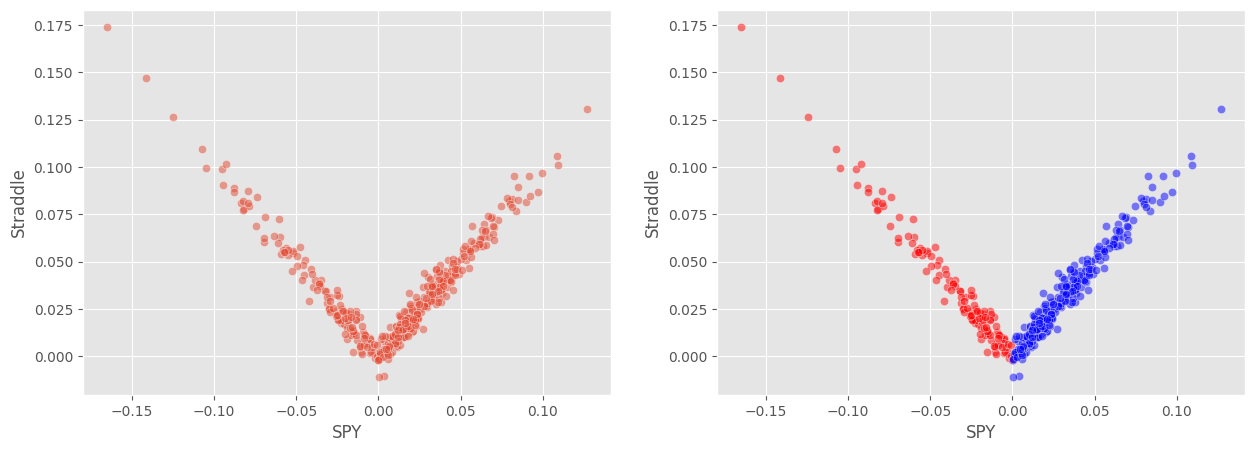

In [48]:
# That was pretty easy, but what if our payoff function is more complicated? Let's
# say we're long a straddle at 0.00 returns (ie. ATM). 

ex['Straddle'] = np.abs(spy)
ex['Straddle'] = ex['Straddle'] + np.random.normal(0, 0.005, size=len(ex))

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(15, 5))

sns.scatterplot(x='SPY', y='Straddle', data=ex, alpha=0.5, ax=axes[0])

# Then we can decompose the payoff into a linear combination of basis functions.
# Plot where spy < 0 red and spy > 0 blue
sns.scatterplot(x='SPY', y='Straddle', data=ex[ex['SPY'] < 0], alpha=0.5, ax=axes[1], color='red')
sns.scatterplot(x='SPY', y='Straddle', data=ex[ex['SPY'] > 0], alpha=0.5, ax=axes[1], color='blue');

In [49]:
# We can fit a linear model to this data, by dividing it into a "put like" factor, and a "call like" factor
ex['Put'] = ex['SPY'].copy()
ex['Put'][ex['SPY'] > 0] = 0
ex['Put'] = np.abs(ex['Put'])
ex['Call'] = ex['SPY'].copy()
ex['Call'][ex['SPY'] < 0] = 0
ex['Call'] = np.abs(ex['Call'])

# Fit linear regression
model = sm.OLS(ex['Straddle'], ex[['Put', 'Call', 'SPY']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Straddle   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.467e+04
Date:                Wed, 04 Dec 2024   Prob (F-statistic):                        0.00
Time:                        17:02:19   Log-Likelihood:                          1479.9
No. Observations:                 381   AIC:                                     -2956.
Df Residuals:                     379   BIC:                                     -2948.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Put            1.0038      0.007    152.832      0.000       0.991       1.017
Call           1.0009      0.006    168.854      0.000       0.989       1.013
SPY           -0.0029      0.004     -0.727      0.468      -0.011       0.005
==============================================================================
Omnibus:                        2.764   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.251   Jarque-Bera (JB):                2.495
Skew:                           0.175   Prob(JB):                        0.287
Kurtosis:                       3.186   Cond. No.                     9.96e+15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The smallest eigenvalue is 1.12e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

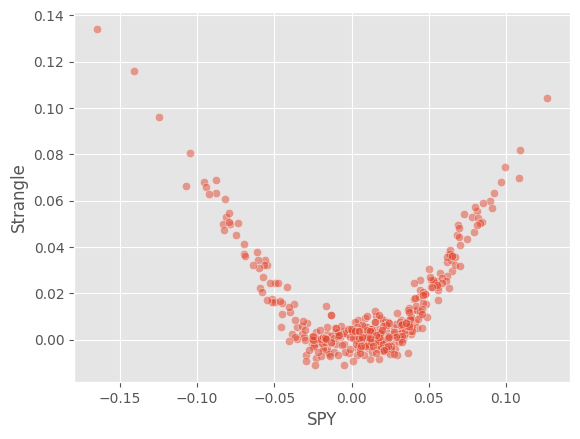

In [50]:
# Actually, suppose we are long a strangle at -0.03 and 0.03 returns (ie. OTM). 
# And, we are also long SPY.
ex['Strangle'] = np.maximum(spy - 0.03, 0) + np.maximum(-0.03 - spy, 0)
ex['Strangle'] = ex['Strangle'] + np.random.normal(0, 0.005, size=len(ex))

sns.scatterplot(x='SPY', y='Strangle', data=ex, alpha=0.5);

In [51]:
# And now linearly decompose the payoff into a linear combination of basis functions.
ex['STG_Put'] = np.maximum(-0.03 - spy, 0)
ex['STG_Call'] = np.maximum(spy - 0.03, 0)
ex['STG_Spy'] = spy
ex['STG_Spy2'] = spy**2

# Fit linear regression
model = sm.OLS(ex['Strangle'], ex[['STG_Put', 'STG_Call', 'STG_Spy', 'STG_Spy2']])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               Strangle   R-squared (uncentered):                   0.962
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              2410.
Date:                Wed, 04 Dec 2024   Prob (F-statistic):                   5.84e-267
Time:                        17:02:20   Log-Likelihood:                          1489.4
No. Observations:                 381   AIC:                                     -2971.
Df Residuals:                     377   BIC:                                     -2955.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
STG_Put        1.0600      0.072     14.810      0.000       0.919       1.201
STG_Call       0.9866      0.056     17.741      0.000       0.877       1.096
STG_Spy        0.0209      0.014      1.469      0.143      -0.007       0.049
STG_Spy2      -0.0734      0.403     -0.182      0.856      -0.866       0.719
==============================================================================
Omnibus:                        0.031   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.985   Jarque-Bera (JB):                0.093
Skew:                           0.017   Prob(JB):                        0.955
Kurtosis:                       2.932   Cond. No.                         76.4
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

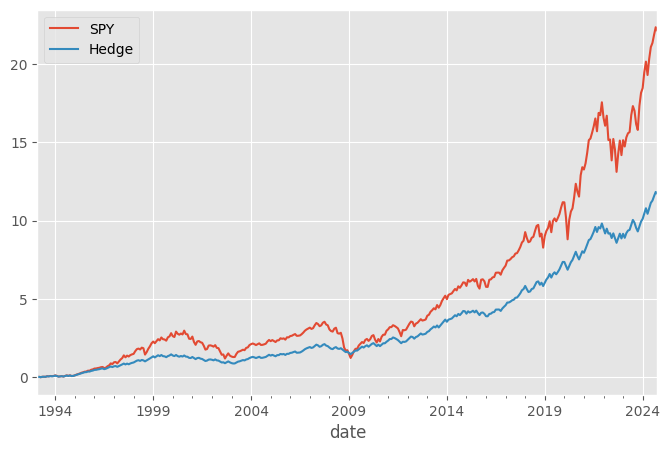

In [52]:
# One potential application is so-called "downside protection" or "PnL smoothing". This is very popular in hedge funds and 
# other asset managers. The idea is that you want to protect your portfolio from large losses, but you don't want to give up
# too much upside.

# So, you buy a put option. The problem with this is that it might be expensive to buy a put option.
# Why don't we give up some upside to pay for the put option and make it cheaper? We do this by selling a call option.

# Eg. Put options might cost $10, and call options might cost $5. So we enter into long put, short call position, and pay $5.
# this lets us buy *double* the number of put options. Also, note that selling a call also somewhat helps our downside protection,
# since we are short more deltas!

# Let's see how this works in practice. Let's say we are long SPY, and we want to protect against a 10% drop in SPY.
ex['Hedge'] = spy.copy() - np.maximum(spy - 0.03, 0) + np.maximum(-0.03 - spy, 0)

# Plot cumulative returns
((1 + ex[['SPY', 'Hedge']]).cumprod() - 1).plot(figsize=(8, 5));

In [53]:
ta.calc_performance_metrics(ex[['SPY', 'Hedge']], adj=12).T

,SPY,Hedge
Annualized Return,0.110423,0.083535
Annualized Volatility,0.1482,0.0797
Annualized Sharpe Ratio,0.745093,1.048117
Annualized Sortino Ratio,1.032201,2.573276
Skewness,-0.590816,-0.509181
Excess Kurtosis,0.993945,-1.305678
VaR (0.05),-0.069606,-0.03
CVaR (0.05),-0.094317,-0.03
Min,-0.165187,-0.03
Max,0.126983,0.03


In [54]:
ta.calc_univariate_regression(ex['Hedge'], ex['SPY']).T

,Hedge
Alpha,0.029883
Beta,0.485875
Downside Beta,0.218761
R-Squared,0.816267
Treynor Ratio,0.171926
Information Ratio,0.874728
Tracking Error,0.002847


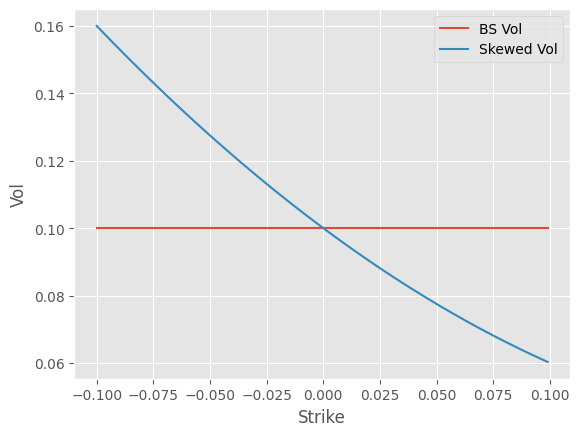

In [55]:
# Is this too good to be true? Well, yes. This is one of the reasons why the volatility surface is asymmetric!

# Plot -0.1 to 0.1 vs. constant vol of 5%
xx = np.arange(-0.1, 0.1, 0.001)
plt.plot(xx, np.full(len(xx), 0.1), label='BS Vol')
yy = 0.1 -0.5 * xx + (xx) **2
plt.plot(xx, yy, label='Skewed Vol')
plt.legend()
plt.xlabel('Strike')
plt.ylabel('Vol')
plt.show()

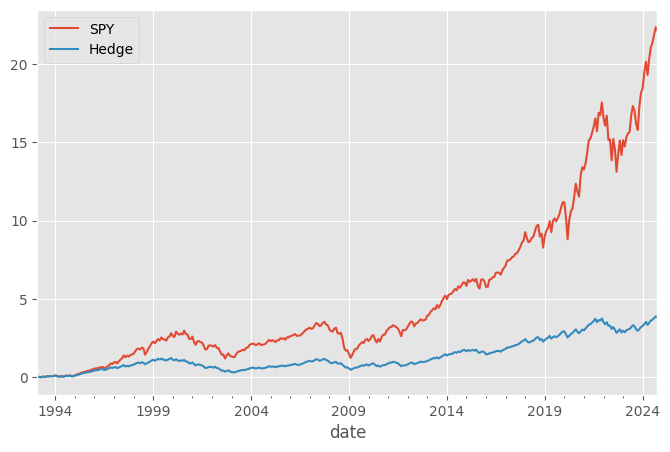

In [56]:
ex['Hedge'] = spy.copy() - np.maximum(spy - 0.03, 0) + np.maximum(-0.05 - spy, 0)

# Plot cumulative returns
((1 + ex[['SPY', 'Hedge']]).cumprod() - 1).plot(figsize=(8, 5));

In [57]:
ta.calc_performance_metrics(ex[['SPY', 'Hedge']], adj=12).T

,SPY,Hedge
Annualized Return,0.110423,0.054307
Annualized Volatility,0.1482,0.094815
Annualized Sharpe Ratio,0.745093,0.572773
Annualized Sortino Ratio,1.032201,0.929637
Skewness,-0.590816,-0.812658
Excess Kurtosis,0.993945,-0.678808
VaR (0.05),-0.069606,-0.05
CVaR (0.05),-0.094317,-0.05
Min,-0.165187,-0.05
Max,0.126983,0.03


What is the point of this HW? We're trying to engineer features to better explain the returns of the portfolio. This is generally very useful, because it allows us to understand the risks of the portfolio, and then hedge them accordingly, or, "load up" on them synthetically.

![](https://pbs.twimg.com/media/F_IIOc-W4AA49Ff?format=jpg&name=900x900)